In [1]:
from model.dl_model import DeepLearningModel
from Preprocess.data_cleaning import LowerCase, RemoveURL, RemoveEmojis, RemovePunctuations, RemoveStopWords

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras import layers

import pandas as pd
import keras

[nltk_data] Downloading package stopwords to C:\Users\Harshana
[nltk_data]     Lakmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Harshana
[nltk_data]     Lakmal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Harshana
[nltk_data]     Lakmal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Harshana
[nltk_data]     Lakmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pd.set_option("future.no_silent_downcasting", True)

In [3]:
data: pd.DataFrame = pd.read_csv("Data/bbc_data.csv")
data.head(2)

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment


In [4]:
data_cleaning_pipe: Pipeline = Pipeline(
    steps=[
        ("lowe_case", LowerCase()),
        ("remove_url", RemoveURL()),
        ("remove_emojis", RemoveEmojis()),
        ("remove_punchuarions", RemovePunctuations()),
        ("remove_stop_words", RemoveStopWords()),
    ]
)

data["cleaned_text"] = data_cleaning_pipe.fit_transform(data["data"], data["labels"])
data["labels"].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

In [5]:
"""
Encode class label to numberic values.
"""

label_dictionary = {"entertainment": 0, "business": 1, "sport": 2, "politics": 3, "tech": 4}
data["labels"] = data["labels"].replace(label_dictionary)
data["labels"].unique()

array([0, 1, 2, 3, 4], dtype=object)

In [6]:
"""
Select "cleaned_text" from preprocessing level as features and "labels" as labels.
"""

features = list(data["cleaned_text"])
labels = list(data["labels"])

In [7]:
"""
Train & Test split on 80% & 20% ratio.
"""

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2)

In [18]:
"""
Simple sequential deep learning model.
"""


class SequentialModel(keras.Model):
    def __init__(self, num_unique_words, num_classes):
        super(SequentialModel, self).__init__()
        self.unique_word_count: int = num_unique_words
        self.num_classes: int = num_classes

        self.embedded_sequences = layers.Embedding(self.unique_word_count, 128, mask_zero=False, name="embedding_layer")
        self.dense1 = layers.Dense(128, activation="relu")
        self.dense2 = layers.Dense(64, activation="relu")
        self.dropout = layers.Dropout(0.05)
        # self.dense3 = layers.Dense(32, activation="relu")
        self.pooled_output = layers.GlobalMaxPooling1D()
        self.output_layer = layers.Dense(self.num_classes, activation="softmax")

    def call(self, inputs):
        x = self.embedded_sequences(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dropout(x)
        # x = self.dense3(x)
        x = self.pooled_output(x)

        return self.output_layer(x)

In [19]:
squential_model = DeepLearningModel(
    dl_model=SequentialModel, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, padding_length=200, label_dictionary=label_dictionary
)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.3131 - auc: 0.8349 - loss: 1.5711 - precision: 0.9034 - recall: 0.2905 - val_accuracy: 0.7191 - val_auc: 0.8803 - val_loss: 1.4095 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7724 - auc: 0.9240 - loss: 1.3211 - precision: 0.3125 - recall: 0.0012 - val_accuracy: 0.8427 - val_auc: 0.9662 - val_loss: 1.0513 - val_precision: 1.0000 - val_recall: 0.0787
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8655 - auc: 0.9760 - loss: 0.9171 - precision: 0.9910 - recall: 0.2621 - val_accuracy: 0.9101 - val_auc: 0.9872 - val_loss: 0.6121 - val_precision: 0.9837 - val_recall: 0.6770
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9274 - auc: 0.9937 - loss: 0.4837 - precision: 0.9855 - recall: 0.7865 - val_accuracy: 0.9494 - val_auc: 0.9944 - val_loss: 0.3341 - val_precision: 0.9711 - val_recall: 0.8483
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━

In [21]:
squential_model.classification_report()

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        78
           1       0.92      0.94      0.93        98
           2       0.97      0.96      0.97       104
           3       0.93      0.97      0.95        94
           4       0.99      0.94      0.96        71

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



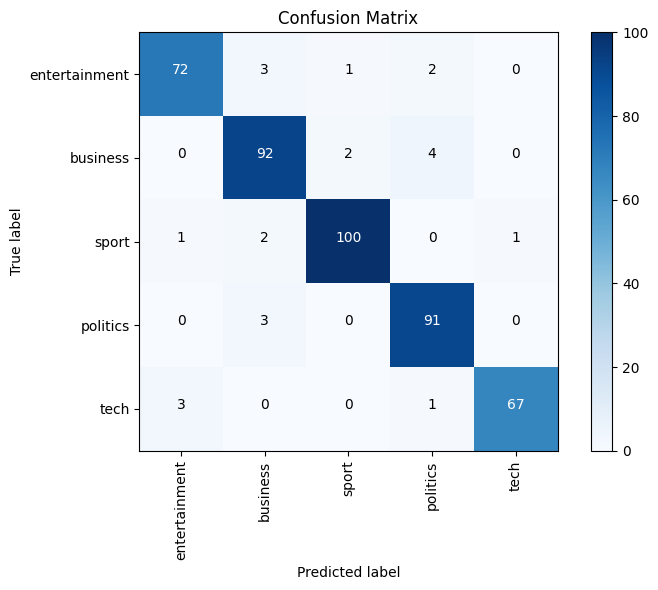

In [20]:
squential_model.plot_confution_matrix()

In [22]:
"""
Bidirectional LSTM deep learning model.
"""


class LSTMModel(keras.Model):
    def __init__(self, num_unique_words, num_classes):
        super(LSTMModel, self).__init__()
        self.unique_word_count: int = num_unique_words
        self.num_classes: int = num_classes

        self.embedded_sequences = layers.Embedding(self.unique_word_count, 128, mask_zero=False, name="embedding_layer")
        self.bilstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        self.dense1 = layers.Dense(64, activation="relu")
        self.dropout = layers.Dropout(0.05)
        self.pooled_output = layers.GlobalMaxPooling1D()
        self.output_layer = layers.Dense(self.num_classes, activation="softmax")

    def call(self, inputs):
        x = self.embedded_sequences(inputs)
        x = self.bilstm(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.pooled_output(x)

        return self.output_layer(x)

In [24]:
lstm_model = DeepLearningModel(
    dl_model=LSTMModel, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, padding_length=200, label_dictionary=label_dictionary
)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 579ms/step - accuracy: 0.2660 - auc: 0.8010 - loss: 1.5795 - precision: 0.9377 - recall: 0.3315 - val_accuracy: 0.4607 - val_auc: 0.7301 - val_loss: 1.4867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step - accuracy: 0.5392 - auc: 0.7602 - loss: 1.4259 - precision: 0.3243 - recall: 0.0097 - val_accuracy: 0.5815 - val_auc: 0.8581 - val_loss: 1.0843 - val_precision: 0.6337 - val_recall: 0.3062
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 549ms/step - accuracy: 0.6688 - auc: 0.9283 - loss: 0.7980 - precision: 0.7489 - recall: 0.5368 - val_accuracy: 0.8736 - val_auc: 0.9586 - val_loss: 0.5496 - val_precision: 0.9015 - val_recall: 0.8483
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 548ms/step - accuracy: 0.9077 - auc: 0.9732 - loss: 0.4318 - precision: 0.9184 - recall: 0.8931 - val_accuracy: 0.9185 - val_auc: 0.9883 - val_loss: 0.2908 - val_precision: 0.9339 - val_recall: 0.9129
Epoch 5/5
15/15 ━━━━━━━━━━━

In [25]:
lstm_model.classification_report()

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        78
           1       0.87      0.87      0.87        98
           2       0.95      0.98      0.97       104
           3       0.99      0.87      0.93        94
           4       0.78      0.94      0.85        71

    accuracy                           0.91       445
   macro avg       0.91      0.91      0.91       445
weighted avg       0.92      0.91      0.91       445



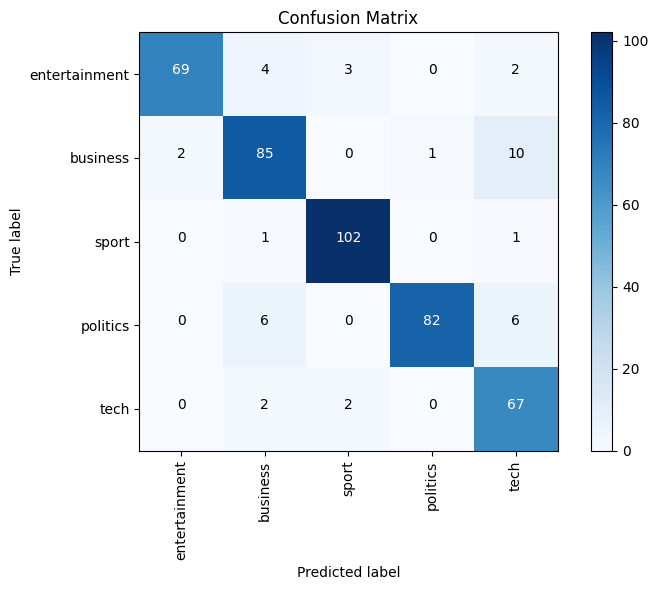

In [26]:
lstm_model.plot_confution_matrix()

In [27]:
"""
Simple RNN deep learning model.
"""


class RNNModel(keras.Model):
    def __init__(self, num_unique_words, num_classes):
        super(RNNModel, self).__init__()
        self.unique_word_count: int = num_unique_words
        self.num_classes: int = num_classes

        self.embedded_sequences = layers.Embedding(self.unique_word_count, 128, mask_zero=False, name="embedding_layer")
        self.rnn = layers.SimpleRNN(128, return_sequences=True)
        self.dense1 = layers.Dense(64, activation="relu")
        self.dropout = layers.Dropout(0.05)
        self.pooled_output = layers.GlobalMaxPooling1D()
        self.output_layer = layers.Dense(self.num_classes, activation="softmax")

    def call(self, inputs):
        x = self.embedded_sequences(inputs)
        x = self.rnn(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.pooled_output(x)

        return self.output_layer(x)

In [28]:
rnn_model = DeepLearningModel(
    dl_model=LSTMModel, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, padding_length=200, label_dictionary=label_dictionary
)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 613ms/step - accuracy: 0.2528 - auc: 0.8017 - loss: 1.5784 - precision: 0.9270 - recall: 0.3305 - val_accuracy: 0.2978 - val_auc: 0.7158 - val_loss: 1.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - accuracy: 0.3640 - auc: 0.7401 - loss: 1.4020 - precision: 0.4858 - recall: 0.0282 - val_accuracy: 0.6096 - val_auc: 0.9011 - val_loss: 0.9028 - val_precision: 0.7130 - val_recall: 0.4607
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 613ms/step - accuracy: 0.6763 - auc: 0.9304 - loss: 0.7575 - precision: 0.7344 - recall: 0.5657 - val_accuracy: 0.7781 - val_auc: 0.9551 - val_loss: 0.6423 - val_precision: 0.8123 - val_recall: 0.7051
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step - accuracy: 0.8513 - auc: 0.9676 - loss: 0.5665 - precision: 0.8984 - recall: 0.7978 - val_accuracy: 0.8539 - val_auc: 0.9680 - val_loss: 0.4693 - val_precision: 0.8580 - val_recall: 0.8483
Epoch 5/5
15/15 ━━━━━━━━━━━

In [29]:
rnn_model.classification_report()

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        78
           1       0.91      0.85      0.88        98
           2       0.96      0.99      0.98       104
           3       0.86      0.91      0.89        94
           4       0.88      0.90      0.89        71

    accuracy                           0.90       445
   macro avg       0.90      0.90      0.90       445
weighted avg       0.90      0.90      0.90       445



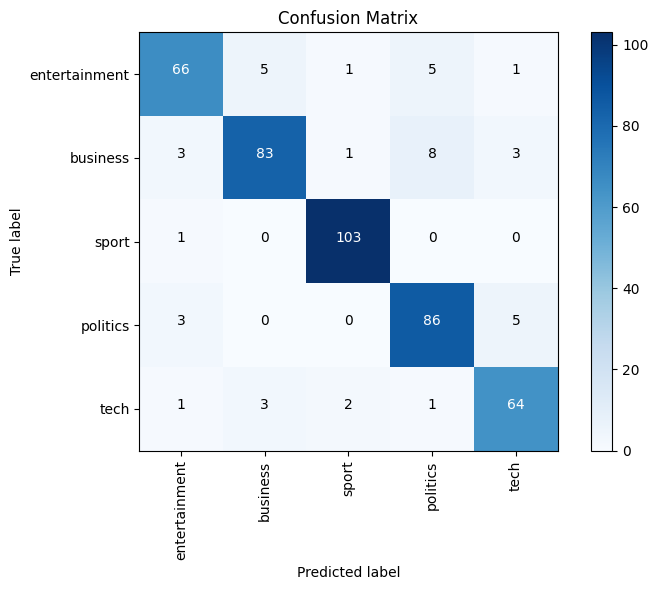

In [30]:
rnn_model.plot_confution_matrix()